In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from helpers import imshow
from pygame import mixer

In [5]:
# ORB Functions
""" Clear matches for which NN ratio is > than threshold """
def filter_distance(matches,ratio):
    dist = [m.distance for m in matches]
    thres_dist = (sum(dist) / len(dist)) * ratio

    # keep only the reasonable matches
    sel_matches = [m for m in matches if m.distance < thres_dist]
    #print '#selected matches:%d (out of %d)' % (len(sel_matches), len(matches))
    return sel_matches

""" keep only symmetric matches """
def filter_asymmetric(matches, matches2):
    sel_matches = []
    for match1 in matches:
        for match2 in matches2:
            if k_ftr[match1.queryIdx] == k_ftr[match2.trainIdx] and k_scene[match1.trainIdx] == k_scene[match2.queryIdx]:
                sel_matches.append(match1)
                break
    return sel_matches

# Todo: filter_ransac

def filter_matches(matches, matches2):
    matches = filter_distance(matches)
    matches2 = filter_distance(matches2)
    return filter_asymmetric(matches, matches2)

def recArea(dst):
    qp = dst
    #tl = qp[0][0] #top left
    #bl = qp[0][1] #botton left
    #br = qp[0][2] #botton right
    #tr = qp[0][3] #top right
    qp = qp[0] #qp stores all the points
    area = 0
    j = 3
    for i in range(4):
        area = area + (qp[j][0]+qp[i][0])*(qp[j][1]-qp[i][1])
        j = i
    return area/2

def orbTrack(trainImg,trainKP,trainDesc,QueryImgBGR,h,w):
    MIN_MATCH_COUNT=15

    detector=cv2.ORB_create()

    #FLANN_INDEX_KDITREE=0
    #flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    #searchParam = dict(checks=50)
    #flann=cv2.FlannBasedMatcher(flannParam,searchParam)
    #flann=cv2.FlannBasedMatcher(flannParam,{})
    
    QueryImg=cv2.cvtColor(QueryImgBGR,cv2.COLOR_BGR2GRAY)
    queryKP,queryDesc=detector.detectAndCompute(QueryImg,None)
    #matches=flann.knnMatch(queryDesc,trainDesc,k=2)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    #matches = bf.knnMatch(queryDesc,trainDesc)
    goodMatchA = bf.match(queryDesc,trainDesc)
    #goodMatchB = bf.match(trainDesc,queryDesc)
    goodMatch = filter_distance(goodMatchA,ratio=0.65)
    #goodMatchB = filter_distance(goodMatchB,ratio=0.65)
    #filter distance
    
    # Sort them in the order of their distance.
    # matches = sorted(matches, key = lambda x:x.distance)
    queryBorder = None
    qp = None
    #print(goodMatch[0]) 
    
    #goodMatch = filter_matches(goodMatchA,goodMatchB)
    #print(len(goodMatch)) 
    if(len(goodMatch) > MIN_MATCH_COUNT):
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        
        #h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        return (1,queryBorder,qp)
        #print(queryBorder)
    else:
        #print("Not Enough match found")
        return (-1,queryBorder,qp)
    
def findOrientation(dst):
    qp = dst
    tl = qp[0][0] #top left
    bl = qp[0][1] #botton left
    br = qp[0][2] #botton right
    tr = qp[0][3] #top right
    center = [(tl[0]+br[0])/2,(tl[1]+br[1])/2]
    x1 = bl[0]
    x2 = br[0]
    y1 = bl[1]
    y2 = br[1]
    if y1 >= y2:
        l = x2 - x1 
        h = y1 - y2
        theta = np.arctan(l/h)/np.pi*360
    else:
        l = x2 - x1
        h = y2 - y1
        theta = 360-(np.arctan(l/h)/np.pi*360)
    
    if theta < 180:
        theta = 90-(theta/2)
    else:
        theta = 450 - (theta/2)
    
    #center is the center of the detected object
    #theta is the angle of it
    return center,theta

In [6]:
def whiteOut(frame):
    #remove white stuff, return a mask of the intsresting stuff
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define range of white color in HSV
    # change it according to your need !
    sensitivity = 14
    #lower_white = np.array([0,0,255-sensitivity])
    #upper_white = np.array([255,sensitivity,255])
    
    lower_white = np.array([0, 0, 255-sensitivity])
    upper_white = np.array([180, sensitivity, 255])
    
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel,iterations = iteration_open)
    
    # applying Morphological Operator to the image to clean the image
    kernel = np.ones((3, 3),np.uint8)
    iteration_close = 1
    res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel,iterations = iteration_close)
    iteration_open = 2
    res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel,iterations = iteration_open)    
    
    return mask,np.abs(255-res)
    #1 - res is what we want, np.multiply(frame,1-res) gives what we want

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    diag = max(nW,nH)
 
    # perform the actual rotation and return the image
    #return [nW,nH],cv2.warpAffine(image, M, (nW, nH),borderValue = (255,255,255))
    return diag,cv2.warpAffine(image, M, (diag, diag),borderValue = (255,255,255))

def new_rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    diag = max(nW,nH)
 
    # perform the actual rotation and return the image
    #return [nW,nH],cv2.warpAffine(image, M, (nW, nH),borderValue = (255,255,255))
    return diag,cv2.warpAffine(image, M, (diag, diag))

def OverLay(background,image,center,theta,scale):
    #first let's recize the image
    h,w,d = image.shape
    h = int(np.floor(h*scale))
    w = int(np.floor(w*scale))
    try:
        resized  = cv2.resize(image,None,fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)#cv2.resize(image, (w,h))
    except:
        return None
    #resized  = image.copy()
    
    #rows,cols,d = resized.shape
    #M = cv2.getRotationMatrix2D((np.floor(cols/2),np.floor(rows/2)),theta,1)
    
    #this line needs to be changed for better performance
    #diag = int(np.floor(np.sqrt(rows*rows+cols*cols)))
    #diag = int(np.maximum(rows,cols))
    #dst = cv2.warpAffine(resized,M,(diag,diag),borderValue = (255,255,255))
    
    diag, dst = rotate_bound(resized, theta)
    #diag = int(np.floor(np.sqrt(nW*nW+nH*nH)))
#     imshow(dst)
       
    #h,w,d = dst.shape
    mask,res = whiteOut(dst)
    #imshow(res)
    
    x_center = center[0]
    y_center = center[1]
    
    result = background.copy()
    cols,rows,d = result.shape
    
    tx = np.floor(x_center - diag/2)
    #xcenter
    ty = np.floor(y_center - diag/2)
    #ycenter
    
    
    Ry0 = int(ty)
    Ry1 = int(ty+diag)
    #Ry1 = int(ty+nH)
    Rx0 = int(tx)
    Rx1 = int(tx+diag)
    #Rx1 = int(tx+nW)
    Fy0 = int(0)
    Fy1 = int(0+diag)
    #Fy1 = int(0+nH)
    Fx0 = int(0)
    Fx1 = int(0+diag)
    #Fx1 = int(0+nW)
    
    
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    
    #Ry0 = 0
    newImg = result[Ry0:Ry1,Rx0:Rx1,:]
    print(Ry0)
#     imshow(newImg)
    dst = dst[Fy0:Fy1,Fx0:Fx1,:]
    res = res[Fy0:Fy1,Fx0:Fx1,:]
    #imshow(newImg)
    #imshow(dst)
    res2 = np.abs(255-res)
    img2 = cv2.bitwise_and(dst,res)
#     print(newImg.shape,res2.shape)
#     print(dst.shape,res.shape)
    try:
        img3 = cv2.bitwise_and(newImg,res2)
    except:
        print(newImg.shape,res2.shape)
        print(dst.shape,res.shape)
        return  None
    final = np.add(img2,img3)
    result[Ry0:Ry1,Rx0:Rx1] = final
    
    return result

def newOverLay(background,image,center,theta,scale):
    #first let's recize the image
    h,w,d = image.shape
    h = int(np.floor(h*scale))
    w = int(np.floor(w*scale))   
    try:
        resized  = cv2.resize(image,None,fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)#cv2.resize(image, (w,h))
    except:
        return None
    
    #rows,cols,d = resized.shape
    #M = cv2.getRotationMatrix2D((np.floor(cols/2),np.floor(rows/2)),theta,1)
    
    #this line needs to be changed for better performance
    #diag = int(np.floor(np.sqrt(rows*rows+cols*cols)))
    #diag = int(np.maximum(rows,cols))
    #dst = cv2.warpAffine(resized,M,(diag,diag),borderValue = (255,255,255))
    
    diag,res = new_rotate_bound(resized,theta)       
    #h,w,d = dst.shape
    
    x_center = center[0]
    y_center = center[1]
    
    result = background.copy()
    cols,rows,d = result.shape
    
    tx = np.floor(x_center - diag/2)
    #xcenter
    ty = np.floor(y_center - diag/2)
    #ycenter
    
    
    Ry0 = int(ty)
    Ry1 = int(ty+diag)
    #Ry1 = int(ty+nH)
    Rx0 = int(tx)
    Rx1 = int(tx+diag)
    #Rx1 = int(tx+nW)
    Fy0 = int(0)
    Fy1 = int(0+diag)
    #Fy1 = int(0+nH)
    Fx0 = int(0)
    Fx1 = int(0+diag)
    #Fx1 = int(0+nW)
    
    
    if tx < 0 or ty < 0 or int(tx + diag) > rows or int(ty+diag) > cols:
        if tx < 0:
            Rx0 = 0
            Rx1 = int(diag-abs(tx))
            Fx0 = int(abs(tx))
        if ty < 0:
            Ry0 = 0
            Ry1 = int(diag-abs(ty))
            Fy0 = int(abs(ty))
        if int(tx + diag) > rows:
            Rx0 = rows - (diag - (int(tx + diag)-rows)) 
            Rx1 = rows
            Fx1 = int(0+diag-(int(tx+diag)-rows)) 
        if int(ty + diag) > cols:
            Ry0 = cols - (diag - (int(ty + diag)-cols)) 
            Ry1 = cols
            Fy1  = int(0+diag-(int(ty+diag)-cols))
    print(res[Fy0:Fy1,Fx0:Fx1,:].shape)
    print(result[Ry0:Ry1,Rx0:Rx1].shape)
    try:
        img2 = cv2.bitwise_or(res[Fy0:Fy1,Fx0:Fx1,:],result[Ry0:Ry1,Rx0:Rx1,:])
        result[Ry0:Ry1,Rx0:Rx1] = img2
    except:
        return None
    #res[Fy0:Fy1,Fx0:Fx1,:].copyTo(result[Ry0:Ry1,Rx0:Rx1])   
    return result

In [7]:
def getScale(deArea,reArea):
    if reArea < 0:
        return 0.6
    return round(reArea/deArea,2)

In [8]:
def getPeaksAndValleys(samplePoints, thresh_angle, k):
    peaks = {} # Dictionary that stores points corresponding to fingertips
    valleys = {} # Dictionary that stores points corresponding to spaces

    for j in range(len(samplePoints)):

        # determine points corresponding to indices j-k, j and j+k
        jCoord = samplePoints[j][0]
        minusK = samplePoints[(j-k)%len(samplePoints)][0]
        plusK = samplePoints[(j+k)%len(samplePoints)][0]

        kCurv = get_angle(minusK - jCoord, plusK - jCoord)

        if kCurv <= thresh_angle:

            orientation = np.cross(minusK - jCoord, plusK - jCoord)

            if orientation >= 0:
                peaks = update(peaks, j, kCurv, samplePoints)
            else:
                valleys = update(valleys, j, kCurv, samplePoints)
    return peaks, valleys

def getHandContours(mask):
    # Get the contour of the hand and draw it on the original image
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Calculate areas
    areas = [cv2.contourArea(cont) for cont in contours]
    
    # Only keep the largest contour
    if len(contours) == 0:
        return
    cnt = contours[np.argmax(areas)]
    return cnt

def get_angle(v1, v2):
    v1 = v1 / np.linalg.norm(v1) # unit vector v1
    v2 = v2 / np.linalg.norm(v2) # unit vector v2
    cos_theta = np.dot(v1, v2) 
    return np.arccos(cos_theta)*(180/np.pi)

# Helper function to find distance between two vectors
def dist(v1, v2):
    return np.linalg.norm(np.array(v1)-v2)

def update(pointDict, j, kCurv, samplePoints):
    
    for i in pointDict:
        
        # if index j is close to one of the stored indices 
        if abs(i-j) <= 10 or abs(i-j) >= len(samplePoints) - 10:
            
            # if k-curvature of point j is smaller, replace i by it
            if kCurv < pointDict[i]:
                pointDict[j] = kCurv
                del pointDict[i]
            return pointDict                        
    pointDict[j] = kCurv
    return pointDict

In [ ]:
# params = cv2.SimpleBlobDetector_Params()
# params.filterByArea = True
# params.minArea = 2000
# params.filterByCircularity = True
# params.minCircularity = 0.9
# params.filterByConvexity = True
# params.minConvexity = 0.9
# params.minDistBetweenBlobs = 5000
# params.filterByColor = True
# params.blobColor = 0
# detector = cv2.SimpleBlobDetector_create(params)

def segment_skin_ycrcb(img):
    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)    
    
    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([255,173,127],np.uint8)

    # Find region with skin tone in YCrCb image
    mask = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 3)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

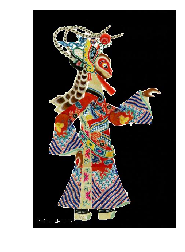

(720, 1144, 3)
(198, 1144, 3)
(720, 1199, 3)
(220, 1199, 3)
(720, 1179, 3)
(220, 1179, 3)
(720, 1268, 3)
(240, 1268, 3)
(720, 1225, 3)
(237, 1225, 3)
(720, 1275, 3)
(403, 1275, 3)
(720, 1216, 3)
(381, 1216, 3)
(720, 1201, 3)
(369, 1201, 3)
(720, 1160, 3)
(352, 1160, 3)
(720, 1067, 3)
(331, 1067, 3)
(720, 1086, 3)
(349, 1086, 3)
(695, 1019, 3)
(695, 1019, 3)
(686, 996, 3)
(686, 996, 3)
(696, 1014, 3)
(696, 1014, 3)
(697, 991, 3)
(697, 991, 3)
(696, 993, 3)
(696, 993, 3)
(706, 980, 3)
(706, 980, 3)
switched
(637, 810, 3)
(637, 810, 3)
(622, 733, 3)
(622, 733, 3)
(609, 678, 3)
(609, 678, 3)
(609, 654, 3)
(609, 654, 3)
(599, 629, 3)
(599, 629, 3)
(600, 633, 3)
(600, 633, 3)
(599, 616, 3)
(599, 616, 3)
(600, 610, 3)
(600, 610, 3)
(590, 590, 3)
(590, 590, 3)
(570, 570, 3)
(570, 570, 3)
(574, 574, 3)
(574, 574, 3)
(548, 548, 3)
(548, 548, 3)
(544, 544, 3)
(544, 544, 3)
(513, 513, 3)
(513, 513, 3)
(512, 512, 3)
(512, 512, 3)
(505, 505, 3)
(505, 505, 3)
(476, 476, 3)
(476, 476, 3)
(473, 473, 3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in arccos


switched
switched
switched
switched
switched
switched
switched
switched
switched
switched
switched
switched
switched


In [ ]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 800
params.filterByCircularity = True
params.minCircularity = 0.5
params.filterByConvexity = False
params.minConvexity = 0.7
detector_pinch = cv2.SimpleBlobDetector_create(params)


cam = cv2.VideoCapture(1)
ret, temp = cam.read()
cam1 = cv2.VideoCapture(0)
img1 = cv2.imread("demo.jpg")
#img1_1 = cv2.imread("demo.jpg")
background_file = 'snow.mp4'
snow_video = cv2.VideoCapture(background_file)
_, background = snow_video.read()#cv2.imread("bk.png")
height, width = temp.shape[:2]
background = cv2.resize(background,(width, height), interpolation = cv2.INTER_CUBIC)
img1 = cv2.flip(img1,1)
#img1_1 = cv2.flip(img1_1,1)
h,w,d = img1.shape
#h1,w1,d1 = img1_1.shape
detector = cv2.ORB_create()
kp1, des1 = detector.detectAndCompute(img1,None)
#kp2, des2 = detector.detectAndCompute(img1_1,None)
snow_frame_counter = 0
background_pinch = None
freeze_time = 0
pinch_switch = False
k = 5
thresh_angle = 70
mask1,res1 = whiteOut(img1)
mask_out1=cv2.subtract(res1,img1)
mask_out1=cv2.subtract(res1,mask_out1)
imshow(mask_out1)

mixer.init()
mixer.music.load('music.mp3')
mixer.music.play()

while True:
    if pinch_switch:
        ret_snow, background = snow_video.read()
        background = cv2.resize(background,(width, height), interpolation = cv2.INTER_CUBIC)
        snow_frame_counter += 1
        if snow_frame_counter == snow_video.get(cv2.CAP_PROP_FRAME_COUNT) - 1:
            snow_frame_counter = 0
            snow_video.release()
            snow_video = cv2.VideoCapture(background_file)
    
    ret, img2 = cam.read()
    img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    img2 = cv2.flip(img2,1)
    checker,dst,_ = orbTrack(img1,kp1,des1,img2,h,w)
    
    #checker2,dst2,qp2 = orbTrack(img1,kp1,des1,img2,h,w)
    
    result = background.copy()
    
    
    ''' Pinch Detection'''
    if freeze_time < 1:
        _, img2_2 = cam1.read()
        img2_2 = cv2.resize(img2_2,None,fx=0.5,fy=0.5)
        img2_for_pinch = cv2.medianBlur(img2_2,19)
        mask_for_pinch = segment_skin_ycrcb(img2_for_pinch)
        keypoints = detector_pinch.detect(mask_for_pinch)
        pinch_detected = False if len(keypoints) < 1 else True
        if pinch_detected:
            pinch_switch = (not pinch_switch)
            print("switched")
            freeze_time = 20
        peaks_count = 0
        if not pinch_detected:
            '''Finger Tracking'''
            img2_modified= cv2.medianBlur(img2_2,9)
            finger_mask = segment_skin_ycrcb(img2_modified)
#             cv2.imshow('sege',finger_mask)
            cnt = getHandContours(finger_mask)
            if cnt is None or len(cnt) <= 300:
                #print("No contours found")
                continue
            else:
                interval = int(len(cnt)/100)
                sample_points = cnt[0:len(cnt):interval] 
                peaks, valleys = getPeaksAndValleys(sample_points, thresh_angle, k)
                #print("Number of fingers detected %d" % (len(peaks)))
                peaks_count = len(peaks)

    #print(pinch_switch)
    freeze_time = freeze_time -1

    if checker != -1:
        #center = findOrientation(qp)
        #mask = cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5)
        center,theta = findOrientation(dst)
        area = recArea(dst)
        scale = getScale(50000,area)
        result = newOverLay(result,mask_out1,[int(center[0]),int(center[1])],theta,scale)
        #result = OverLay(result,img1,[int(center[0]),int(center[1])],theta,scale)


        #cv2.putText(mask, str(area), (int(np.floor(center[0])),int(np.floor(center[1]))), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 255, 255), 2)
        #cv2.circle(mask,(int(np.floor(center[0])),int(np.floor(center[1]))), 3, (0,0,255), -1)
        #cv2.circle(mask,(np.floor(dst[0][1][0]),np.floor(dst[0][1][1])), 3, (0,0,255), -1)
        #cv2.circle(mask,(qp[0][0][0],qp[0][0][q]), 63, (0,0,255), -1)
        #mask = cv2.polylines(mask,[np.int32(dst2)],True,(0,255,0),5)
        #print("YES")
    #checker2,dst2,_ = orbTrack(img1_1,kp2,des2,img2,h1,w1)
    #if checker2 != -1:
        #center = findOrientation(qp)
        #mask = cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5)
     #   center2,theta2 = findOrientation(dst2)
      #  area2 = recArea(dst2)
       # scale2 = getScale(50000,area2)
#         print(scale2)
        #result = OverLay(result,img1_1,[int(center2[0]),int(center2[1])],theta2,scale2)
#     imshow(img2)
    if result is None:
        continue
    if peaks_count == 2 and background_file == 'snow.mp4':
        background_file = 'sunny.mp4'
        #print('changed to sunny')
        snow_frame_counter = 0
        freeze_time = 0
        snow_video.release()
        snow_video = cv2.VideoCapture(background_file)
        _,background = snow_video.read()
        background = cv2.resize(background,(width, height), interpolation = cv2.INTER_CUBIC)
        peaks_count = 0
    elif peaks_count == 2 and background_file == 'sunny.mp4':
        background_file = 'snow.mp4'
        #print('changed to snow')
        snow_frame_counter = 0
        freeze_time = 0
        snow_video.release()
        snow_video = cv2.VideoCapture(background_file)
        _,background = snow_video.read()
        background = cv2.resize(background,(width, height), interpolation = cv2.INTER_CUBIC)
        peaks_count = 0
    
    keypressed = cv2.waitKey(5)
    if keypressed == 32:
        background_pinch = img2_gray
        #print('background saved')
    if keypressed == 27:
        break
    cv2.putText(result,str(pinch_detected),(10,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2,cv2.LINE_AA)
    cv2.putText(result,str(peaks_count),(10,300), cv2.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2,cv2.LINE_AA)
    cv2.imshow('mask',result)
    
cam.release()
cam1.release()
snow_video.release()
cv2.destroyAllWindows()
mixer.music.stop()

In [ ]:
cam.release()
cam1.release()
snow_video.release()
cv2.destroyAllWindows()
mixer.music.stop()